In [1]:
import numpy as np
import matplotlib.pyplot
import statsmodels.api as sms
import pandas as pd
%matplotlib inline

In [2]:
data = pd.read_csv('airline.csv')

In [5]:
data.isnull().sum()

Month                      0
Thousands of Passengers    0
dtype: int64

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Month                    144 non-null    datetime64[ns]
 1   Thousands of Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


In [8]:
data['Month'] = pd.to_datetime(data['Month'])

In [12]:
data.set_index('Month',inplace=True)

<AxesSubplot:xlabel='Month'>

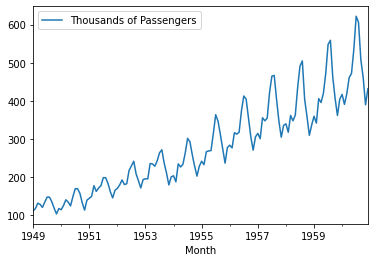

In [14]:
data.plot()
#looks like seasonal data

In [15]:
from statsmodels.tsa.stattools import adfuller

In [17]:
def adf_test(series):
    result = adfuller(series)
    print('ADF statistics: {}'.format(result[0]))
    print("P-value: {}".format(result[1]))
    
    if result[1] <= 0.05:
        print("Reject the null hypothesis. Data is stationary")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root. Data is non-stationary")

In [18]:
adf_test(data['Thousands of Passengers'])

ADF statistics: 0.8153688792060433
P-value: 0.9918802434376409
Weak evidence against null hypothesis, time series has a unit root. Data is non-stationary


In [19]:
#use techniques differencing
data['First difference'] = data['Thousands of Passengers'] - data['Thousands of Passengers'].shift(1)

In [21]:
adf_test(data['First difference'].dropna())

ADF statistics: -2.8292668241699954
P-value: 0.05421329028382609
Weak evidence against null hypothesis, time series has a unit root. Data is non-stationary


In [22]:
data['second difference'] = data['First difference'] - data['First difference'].shift(1)

In [23]:
adf_test(data['second difference'].dropna())

ADF statistics: -16.3842315424685
P-value: 2.7328918500142407e-29
Reject the null hypothesis. Data is stationary


In [27]:
data['12 difference'] = data['Thousands of Passengers'] - data['Thousands of Passengers'].shift(12)

In [28]:
adf_test(data['12 difference'].dropna())

ADF statistics: -3.3830207264924814
P-value: 0.011551493085514952
Reject the null hypothesis. Data is stationary


In [25]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

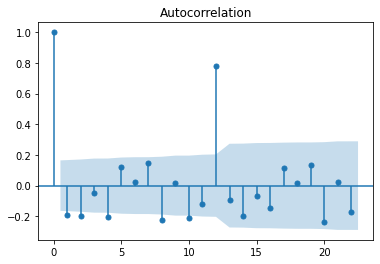

In [29]:
acf = plot_acf(data['second difference'].dropna())

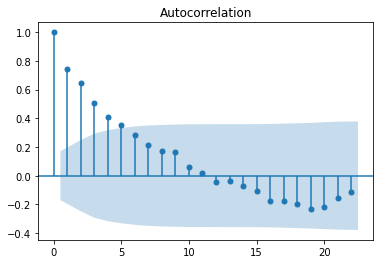

In [30]:
acf12 = plot_acf(data['12 difference'].dropna())

C:\Users\1824306\Anaconda3\envs\nlp\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


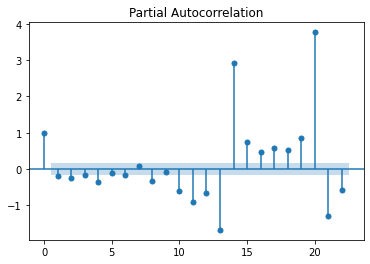

In [31]:
pacf = plot_pacf(data['second difference'].dropna())

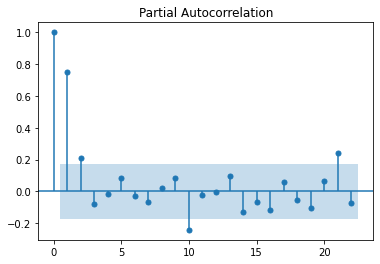

In [32]:
pacf12 = plot_pacf(data['12 difference'].dropna())

In [39]:
from datetime import datetime,timedelta
train_date = datetime(1955,12,1)
test_date = datetime(1960,12,1)

In [40]:
train = data[:train_date]
test  = data[train_date+timedelta(days=1):test_date]


In [42]:
pred_start = test.index[0]
pred_end = test.index[-1]

In [62]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model_SARIMA = SARIMAX(train['Thousands of Passengers'],order=(3,0,5),seasonal_order=(0,1,0,12))

C:\Users\1824306\Anaconda3\envs\nlp\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\1824306\Anaconda3\envs\nlp\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [63]:
model_sarima_fit = model_SARIMA.fit()

C:\Users\1824306\Anaconda3\envs\nlp\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [64]:
model_sarima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:             Thousands of Passengers   No. Observations:                   84
Model:             SARIMAX(3, 0, 5)x(0, 1, [], 12)   Log Likelihood                -265.241
Date:                             Mon, 22 May 2023   AIC                            548.481
Time:                                     12:53:33   BIC                            568.971
Sample:                                 01-01-1949   HQIC                           556.638
                                      - 12-01-1955                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5995      0.938      0.639      0.523      -1.240       2.439
ar.L2          0.8313      0.232      3.577      0.000       0.376       1.287
ar.L3         -0.4539      0.895     -0.507      0.612      -2.207       1.300
ma.L1          0.1825      1.167      0.156      0.876      -2.104       2.469
ma.L2         -0.5354      1.265     -0.423      0.672      -3.015       1.944
ma.L3         -0.0985      0.385     -0.256      0.798      -0.853       0.656
ma.L4         -0.1270      0.338     -0.376      0.707      -0.789       0.535
ma.L5          0.2472      0.357      0.692      0.489      -0.453       0.947
sigma2        87.7190     81.326      1.079      0.281     -71.678     247.116
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 2.68
Prob(Q):                              0.88   Prob(JB):                         0.26
Heteroskedasticity (H):               2.05   Skew:                             0.46
Prob(H) (two-sided):                  0.09   Kurtosis:                         2.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [66]:
predictions = model_sarima_fit.predict(start=pred_start,end=pred_end)

In [67]:
residuals = test['Thousands of Passengers'] - predictions

<AxesSubplot:ylabel='Density'>

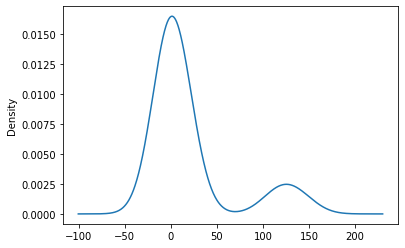

In [68]:
model_sarima_fit.resid.plot(kind='kde')

In [70]:
test['predicted_SARIMA' ]=predictions

C:\Users\1824306\Anaconda3\envs\nlp\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='Month'>

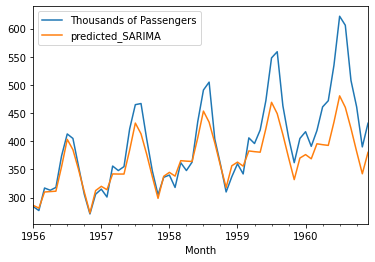

In [72]:
test[['Thousands of Passengers', 'predicted_SARIMA']].plot()